<a href="https://colab.research.google.com/github/AbeRodz/Machine-learning/blob/analisis_inicial/Analisis_inicial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install geopandas pyshp contextily

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 344.8 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 50.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 kB 3.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd drive/MyDrive/dataset/

/content/drive/MyDrive/dataset


In [4]:
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as colors
import shapefile as shp
import seaborn as sns
import numpy as np
import geopandas as gpd

In [5]:
geo_map = gpd.read_file("./shapefiles/taxi_zones.shp")

In [6]:
geo_map

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."
...,...,...,...,...,...,...,...
258,259,0.126750,0.000395,Woodlawn/Wakefield,259,Bronx,"POLYGON ((1025414.782 270986.139, 1025138.624 ..."
259,260,0.133514,0.000422,Woodside,260,Queens,"POLYGON ((1011466.966 216463.005, 1011545.889 ..."
260,261,0.027120,0.000034,World Trade Center,261,Manhattan,"POLYGON ((980555.204 196138.486, 980570.792 19..."
261,262,0.049064,0.000122,Yorkville East,262,Manhattan,"MULTIPOLYGON (((999804.795 224498.527, 999824...."


## UTILITY FUNCTIONS

In [7]:
def open_sample_from_file(path : str,column_to_search: str = None , search_value:str = None, show_columns = False) -> pd.DataFrame:
    """
    Helper function to read a file sample with optional search conditions
    """
    parquet = path.endswith('parquet')
    func = getattr(pd, f'read_csv')
    if parquet:
        engine = 'auto'
        func = getattr(pd, f'read_parquet')
        return func(path, engine)
    
    if column_to_search:
        if search_value != None:
            df = func(path)
            return df[df[column_to_search] == search_value]
        
        return func(path)[column_to_search] 

    if show_columns:
        return func(path).columns

    return func(path)

In [8]:
def get_memory_usage(df):
  print(f"Memory used on DataFrame: {np.round(df.memory_usage(deep=True).sum()/(2**20),2)}MB")

In [9]:
def open_season(path: str = "./dataset/",season: str = "winter",open_all = False, drop_values = True, sample_divisor = 10) -> pd.DataFrame:
    """
    Helper function to open and separate the dataset on seasons.

    winter  01-01 -> - 02-28 (59 days of the year)
    spring  03-01 -> 05-31
    summer 06-01 -> 08-31
    autumn 09-01 -> 11-31
    """
    seasons = {"winter":[path + "yellow_tripdata_2022-01.parquet",path + "yellow_tripdata_2022-02.parquet"
                          ],
               "spring":[path +"yellow_tripdata_2022-03.parquet",path +"yellow_tripdata_2022-04.parquet",path + "yellow_tripdata_2022-05.parquet"
                          ],
               "summer":[path + "yellow_tripdata_2022-06.parquet",path +"yellow_tripdata_2022-07.parquet",path + "yellow_tripdata_2022-08.parquet"
                          ],
               "autumn" :[path + "yellow_tripdata_2022-09.parquet",path +"yellow_tripdata_2022-10.parquet",path + "yellow_tripdata_2022-11.parquet"
                          ]
               }
    
    if open_all:
      df = pd.DataFrame()
      for i in seasons:
        df  = pd.concat([pd.read_parquet(seasons.get(i)).drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1), df], ignore_index=True)
        #map(pd.read_parquet, seasons.get(i)), df], ignore_index=True)
      if drop_values:
        #df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
        df = df.sample(int(np.floor(len(df)/sample_divisor)), random_state = 42)
    else:
      if season in seasons:
        df  = pd.concat(
            map(pd.read_parquet, seasons.get(season)), ignore_index=True)
        if drop_values:
          df = df.drop(['VendorID','store_and_fwd_flag', 'extra', 'mta_tax', 'improvement_surcharge', 'congestion_surcharge'], axis=1)
      #df.sample(int(np.floor(len(df)/100)), random_state = 42)
    get_memory_usage(df)
    return df
    

In [15]:
#df = open_season(path = "", open_all = True, sample_divisor = 20)

In [11]:
df = pd.read_parquet("./dataset_sample.parquet", engine = 'auto')

In [3]:
36256548/20


1812827.4

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800429 entries, 0 to 1800428
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float32       
 3   trip_distance          float64       
 4   RatecodeID             float64       
 5   PULocationID           int64         
 6   DOLocationID           int64         
 7   payment_type           uint8         
 8   fare_amount            float32       
 9   tip_amount             float32       
 10  tolls_amount           float32       
 11  total_amount           float32       
 12  airport_fee            float32       
dtypes: datetime64[ns](2), float32(6), float64(2), int64(2), uint8(1)
memory usage: 125.3 MB


### Utilty plot functions (parallel plotting)

In [13]:
import io
from copy import deepcopy
from PIL import Image

def rasterize(fig):
    buf = io.BytesIO()
    fig.savefig(buf, format='png')
    buf.seek(0)
    pil_img = deepcopy(Image.open(buf))
    buf.close()
    
    return pil_img

In [14]:
def plot_distribution_with_info(df:pd.DataFrame = df,fig= None,col_name = None, show_info = False,ax = None, filter = None, title = 'plot'):
  """
  Makes a seaborn kdeplot from a dataFrame sample of the len(df/10), with mean and median displayed on the graph.
  """
  if (col_name is None) and (filter is None):
    return
  if col_name is not None:
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)[col_name]

  if filter is not None:
    df = filter.sample(int(np.floor(len(df)/10)),random_state = 42)
  if ax is None:
    fig, ax = plt.subplots()
  trans = ax.get_xaxis_transform()
  sns.kdeplot( df,ax= ax).set(title=title)
  if show_info:
    mean =df.mean()
    median = df.median()
    plt.axvline(x=mean,
                color='red')
    plt.text(mean, .99, 'mean', color='r', ha='right', va='top', rotation=90, transform=trans)

    plt.axvline(x=median,
                color='blue',
                ls='--', 
                lw=2.5)
    plt.text(median, .99, 'median', color='r', ha='right', va='top', rotation=90, transform=trans)

In [16]:
import matplotlib

def _parallel_plot_worker(data, plot_fn):
    fig = plt.figure(figsize=(5, 5))
    matplotlib.font_manager._get_font.cache_clear()  # necessary to reduce text corruption artifacts
    axes = plt.axes()
    
    plot_fn(df,fig,data,True, axes)
    pil_img = rasterize(fig)
    plt.close()
    
    return pil_img

In [17]:
from multiprocessing import Pool
import matplotlib.pyplot as plt
from functools import partial

def parallel_plot(plot_fn,col_name, grid_shape, figsize=None):
    """
    Helper function for parallel plotting, to speedup big dataset plots
    """
    
    fig, axes = plt.subplots(*grid_shape, figsize=figsize)
    
    with Pool(processes=None) as pool:
        for ax, rastered in zip(axes.ravel(), pool.map(partial(_parallel_plot_worker, plot_fn=plot_fn), col_name)):
            ax.imshow(rastered, aspect='auto')
            ax.get_xaxis().set_ticks([])
            ax.get_yaxis().set_ticks([])
    
    plt.subplots_adjust(hspace=0, wspace=0)
    #fig.tight_layout()
    plt.show()

In [18]:
def drop_column(df, column_name):
  df.drop(column_name, axis =1, inplace = True)
  return df

In [19]:
def calculate_maxes(df: pd.DataFrame, col_name:str):
    total_amount_min = df[col_name].min()
    total_amount_max = df[col_name].max()
    return (total_amount_max,total_amount_min)

## Optimizacion de memoria 

Segun la documentacion de pandas
[Scaling to large datasets](https://pandas.pydata.org/pandas-docs/stable/user_guide/scale.html#load-less-data) hay varias formas de tratar datasets grandes, siendo una de las recomendaciones realizar type downcast que consiste en cambiar los types de las variables a types mas eficientes

En este caso se logra una reduccion de alrededor de 200mb en memoria

In [20]:
def clean_dataFrame(df):

  df = df[df['tpep_pickup_datetime'] != df['tpep_dropoff_datetime']]
  df = df[(df['total_amount'] > 0)]
  #df = df[df['passenger_count']>0]
  df = df.drop_duplicates().reset_index(drop=True)
  get_memory_usage(df)
  return df

In [24]:
df = clean_dataFrame(df)

Memory used on DataFrame: 92.74MB


In [22]:
df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]] = df[["PULocationID","DOLocationID", "RatecodeID","payment_type"]].astype('category')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800429 entries, 0 to 1800428
Data columns (total 13 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   tpep_pickup_datetime   datetime64[ns]
 1   tpep_dropoff_datetime  datetime64[ns]
 2   passenger_count        float32       
 3   trip_distance          float64       
 4   RatecodeID             category      
 5   PULocationID           category      
 6   DOLocationID           category      
 7   payment_type           category      
 8   fare_amount            float32       
 9   tip_amount             float32       
 10  tolls_amount           float32       
 11  total_amount           float32       
 12  airport_fee            float32       
dtypes: category(4), datetime64[ns](2), float32(6), float64(1)
memory usage: 92.7 MB


In [25]:
df[["payment_type"]] = df[["payment_type"]].apply(pd.to_numeric, downcast="unsigned")
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] = \
df[["passenger_count","trip_distance","fare_amount","tip_amount","tolls_amount","total_amount","airport_fee"]] .apply(pd.to_numeric, downcast="float")

In [26]:
get_memory_usage(df)

Memory used on DataFrame: 92.74MB


# TODO
revisar payment type en credit card

## 2. Análisis exploratorio inicial

utilizar el metodo de filtracion mutua y spearman

In [ ]:
# from sklearn.feature_selection import mutual_info_regression, f_regression
# from sklearn.feature_selection import SelectKBest

# def select_features_mutual_info(X_train, y_train, X_test,k= 'all'):  
#   fs = SelectKBest(score_func=mutual_info_regression, k=k )  
#   fs.fit(X_train, y_train)  
#   X_train_fs = fs.transform(X_train)  
#   X_test_fs = fs.transform(X_test)
#   return X_train_fs, X_test_fs, fs
# def select_features_pearson(X_train, y_train, X_test,k= 'all'):  
#   fs = SelectKBest(score_func=f_regression, k=k )  
#   fs.fit(X_train, y_train)  
#   X_train_fs = fs.transform(X_train)  
#   X_test_fs = fs.transform(X_test)
#   return X_train_fs, X_test_fs, fs

# X_train_mi, X_test_mi, mi = select_features_mutual_info(X_train_red, y_train, X_test_red)
# X_train_pc, X_test_pc, pc = select_features_pearson(X_train_red, y_train, X_test_red)
# fig,axes = plt.subplots(2,1,figsize=(16,8))
# axes[0].set_title('Información mutua')
# sns.barplot( x = [c for c in df_train.columns[:-1] ], y = mi.scores_,ax=axes[0])
# axes[1].set_title('Pearson')
# sns.barplot( x = [c for c in df_train.columns[:-1] ], y = pc.scores_,ax=axes[1]); #Grafico el F score de cada feature
# pc.scores_

### Visualizar las primeras filas.

In [27]:
taxi_zones = open_sample_from_file("./taxi+_zone_lookup.csv")

In [28]:
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [29]:
df.head(5)

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
0,2022-11-20 14:50:04,2022-11-20 15:07:36,1.0,2.12,1.0,142,161,2,12.0,0.00,0.00,15.300000,0.00
1,2022-06-01 17:08:02,2022-06-01 18:36:57,1.0,17.40,2.0,132,48,1,52.0,20.25,6.55,87.849998,1.25
2,2022-05-16 21:58:00,2022-05-16 22:06:44,1.0,1.97,1.0,142,236,2,9.0,0.00,0.00,12.800000,0.00
3,2022-10-13 08:52:09,2022-10-13 09:12:49,1.0,2.28,1.0,239,140,1,14.0,1.73,0.00,19.030001,0.00
4,2022-01-27 12:51:16,2022-01-27 12:51:30,1.0,0.00,5.0,209,209,1,63.5,10.00,0.00,76.300003,0.00


## Realizar un resumen de 5 números.

In [30]:
df.describe()

,passenger_count,trip_distance,payment_type,fare_amount,tip_amount,tolls_amount,total_amount,airport_fee
count,1.738347e+06,1.800429e+06,1.800429e+06,1.800429e+06,1.800429e+06,1.800429e+06,1.800429e+06,1.738347e+06
mean,1.399864e+00,6.143297e+00,1.174670e+00,1.479150e+01,2.733493e+00,5.348982e-01,2.160329e+01,9.805004e-02
std,9.640996e-01,6.581227e+02,4.824423e-01,1.561505e+01,3.234919e+00,1.997834e+00,1.869015e+01,3.360786e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,-8.000000e-01,0.000000e+00,0.000000e+00,1.000000e-02,0.000000e+00
25%,1.000000e+00,1.110000e+00,1.000000e+00,7.000000e+00,1.000000e+00,0.000000e+00,1.230000e+01,0.000000e+00
50%,1.000000e+00,1.900000e+00,1.000000e+00,1.000000e+01,2.160000e+00,0.000000e+00,1.596000e+01,0.000000e+00
75%,1.000000e+00,3.570000e+00,1.000000e+00,1.650000e+01,3.360000e+00,0.000000e+00,2.288000e+01,0.000000e+00
max,9.000000e+00,3.571927e+05,4.000000e+00,6.986500e+03,3.880000e+02,9.999000e+01,6.997600e+03,1.250000e+00


### Identificar los tipos de datos: categórico, ordinal, etc. Responder para cada variable su tipo y si es informativa para un problema de clasificación (por ejemplo si se trata de un código, como una matrícula, o un nombre propio).

In [31]:
df.dtypes

tpep_pickup_datetime     datetime64[ns]
tpep_dropoff_datetime    datetime64[ns]
passenger_count                 float32
trip_distance                   float64
RatecodeID                     category
PULocationID                   category
DOLocationID                   category
payment_type                      uint8
fare_amount                     float32
tip_amount                      float32
tolls_amount                    float32
total_amount                    float32
airport_fee                     float32
dtype: object

In [32]:
df['passenger_count'].value_counts()

1.0    1284678
2.0     265444
3.0      69439
0.0      34908
5.0      31841
4.0      30945
6.0      21075
7.0          8
8.0          6
9.0          3
Name: passenger_count, dtype: int64

In [33]:
df['payment_type'].value_counts()

1    1375579
2     352846
0      62082
3       6049
4       3873
Name: payment_type, dtype: int64

In [34]:
df['RatecodeID'].value_counts()

1.0     1645111
2.0       66277
5.0       13734
99.0       6053
3.0        4800
4.0        2351
6.0          21
Name: RatecodeID, dtype: int64

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|VendorID              | int64      | Categórica | Empresa telefonía
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|RatecodeID            | float64    | Categórica | Codigo tarifa
|store_and_fwd_flag    | object     | Categórica | Se guardo en memoria 
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje
|extra                 | float64    |Numerica | Extras
|mta_tax               | float64    |Numerica | Impuesto MTA
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|improvement_surcharge | float64    |Numerica | Recargo por mejoras
|total_amount          | float64    | Numerica| Monto total
|congestion_surcharge  | float64    | Numerica | Recargo por congestión
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |

### Identificar las variables de entrada y de salida del problema. 

### Variables de Entrada

| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|tpep_pickup_datetime  | datetime64 |Fecha/hora | Inicio viaje
|tpep_dropoff_datetime | datetime64 | Fecha/hora | Fin viaje
|passenger_count       | float64    |Numerica | Cantidad pasajeros
|trip_distance         | float64    |Numerica  | Distancia viaje
|PULocationID          | int64      |Categórica | Id zona comienzo
|DOLocationID          | int64      |Categórica | Id zona fin
|payment_type          | int64      | Categórica | Forma de pago
|fare_amount           | float64    |Numerica | Monto del viaje calculado por el taximetro
|tip_amount            | float64    |Numerica | Propina
|tolls_amount          | float64    |Numerica | Monto peajes
|airport_fee           | float64    |Numerica | Tarifa aeropuerto           |



### Analisis por tipo de variable

In [35]:
def display_dataset_distributions(dataset):
    fig = dataset.hist(xlabelsize=8, ylabelsize=8,figsize=(18,10))
    [x.title.set_size(14) for x in fig.ravel()]
    plt.tight_layout()
    plt.show()

In [36]:
numerical_columns = ["passenger_count","trip_distance","fare_amount", "tip_amount","tolls_amount", "total_amount", "airport_fee"]
categorical_columns = ["RatecodeID","PULocationID","DOLocationID", "payment_type"]

## plots categoricos

<Axes: xlabel='RatecodeID', ylabel='count'>

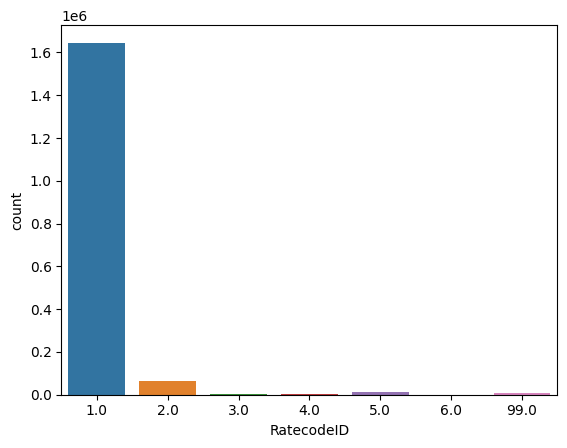

In [39]:
sns.countplot(df, x="RatecodeID")

<Axes: xlabel='payment_type', ylabel='count'>

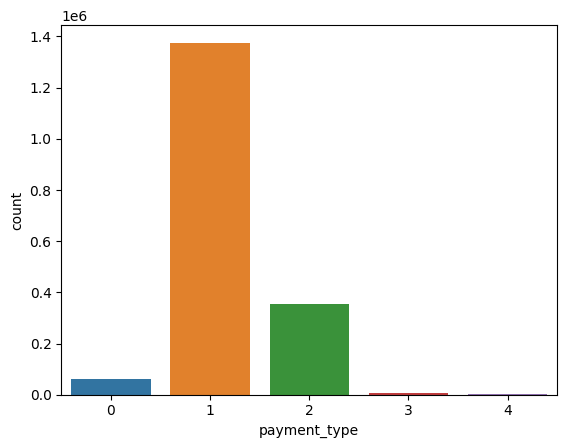

In [40]:
sns.countplot(df, x="payment_type")

<Axes: xlabel='PULocationID', ylabel='count'>

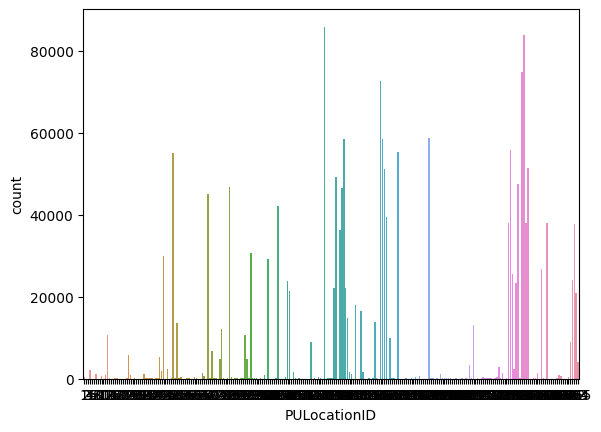

In [42]:
sns.countplot(df, x="PULocationID")

<Axes: xlabel='DOLocationID', ylabel='count'>

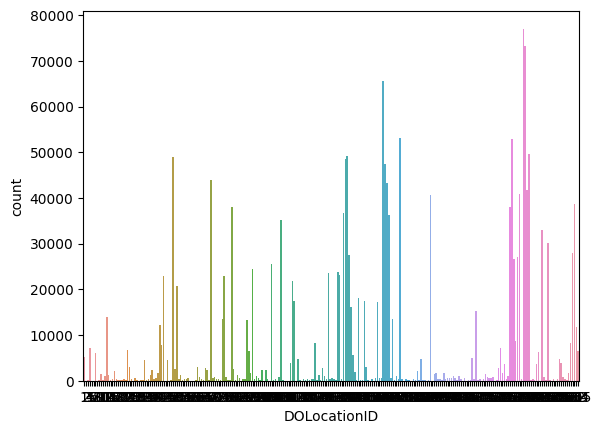

In [43]:
sns.countplot(df, x="DOLocationID")

### Plots Numericos (distribucion de los datos)

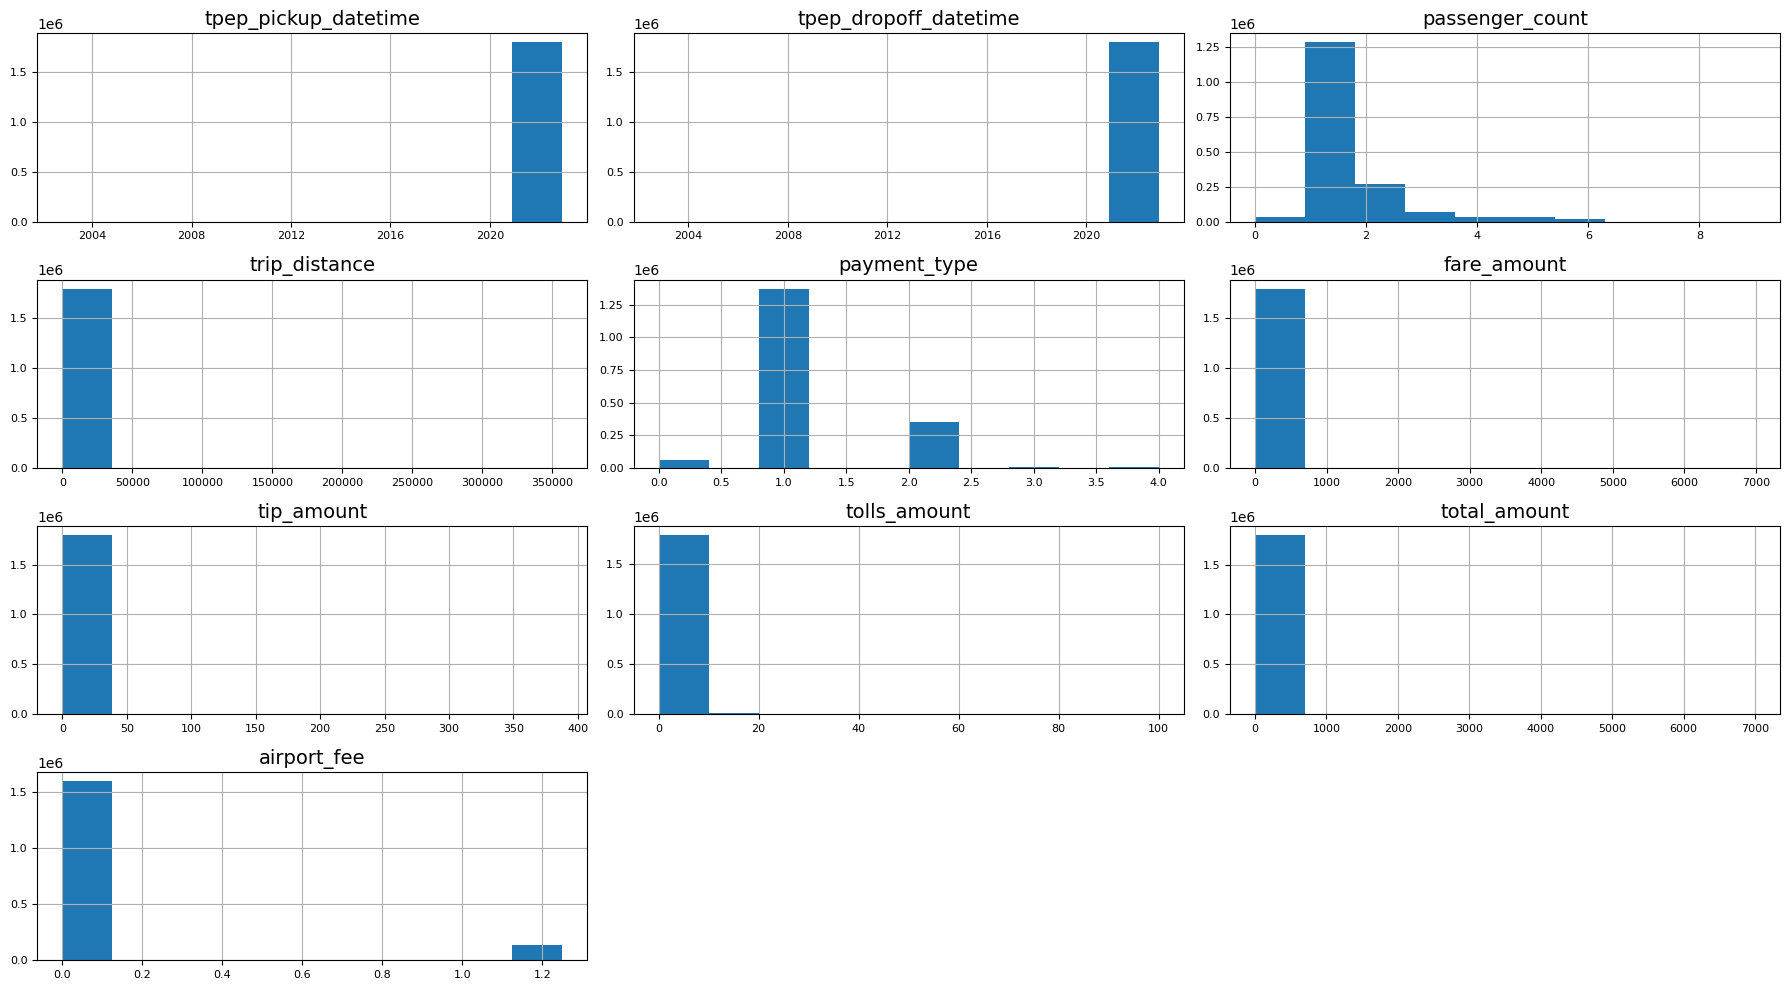

In [44]:
display_dataset_distributions(df)

In [41]:
df.total_amount.median()

15.96

In [42]:
df.total_amount.mode()

0    11.3
Name: total_amount, dtype: float32

In [43]:
df.total_amount.mean()

21.60329

### Veamos total_amount cerca de la media

In [48]:
df.total_amount.value_counts()

11.300000     26782
10.800000     26605
11.800000     26478
10.300000     25783
12.360000     25575
              ...  
113.169998        1
49.939999         1
119.389999        1
116.260002        1
115.980003        1
Name: total_amount, Length: 10912, dtype: int64

# Graficando columnas numericas con mas detalle

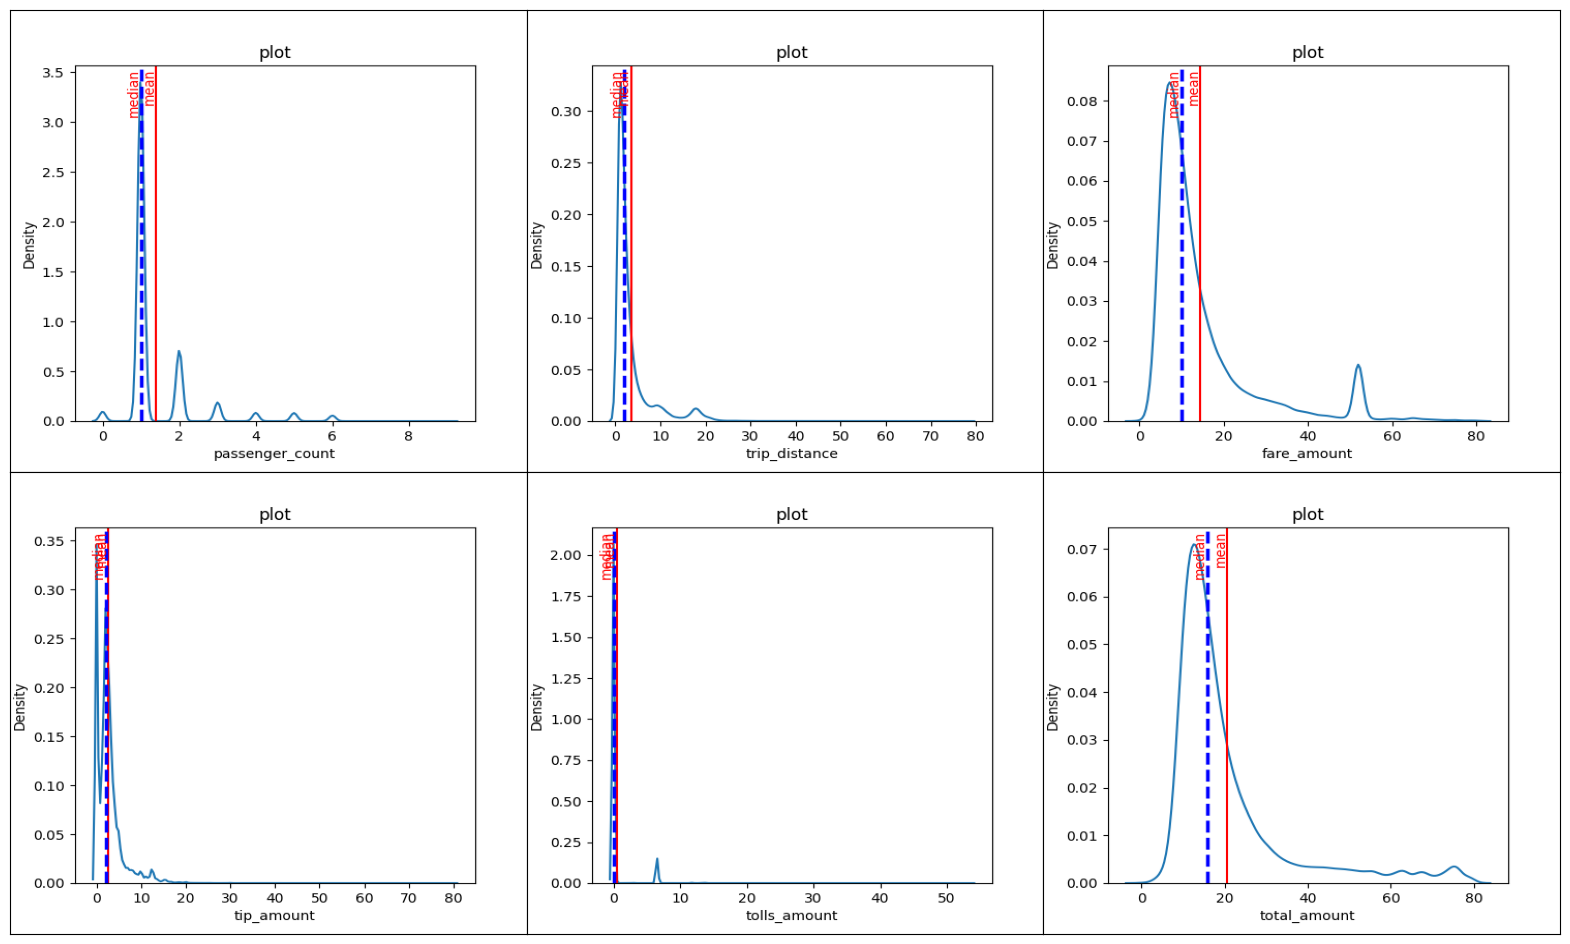

In [44]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= numerical_columns, grid_shape=(2, 3), figsize=(20, 12))

### De las variables tpep_pickup_datetime tpep_dropoff_datetime  se puede obtener mas data, al distribuirla por hora, fecha, duracion de la trayectoria

In [ ]:
# utilzar esta funcion con cuidado, ya que devuelve el dataframe con la columna eliminada
#df = drop_column(df, "weekday")

In [122]:
df['month'] = df['tpep_pickup_datetime'].dt.month_name()

In [37]:
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])
df['date'] = df['tpep_pickup_datetime'].dt.normalize()
df['time_of_day'] = df['tpep_pickup_datetime'].dt.hour
df['month'] = df['tpep_pickup_datetime'].dt.month_name
#df['weekday'] = df['date'].dt.day_name() <- irrelevante?
df['duration_m'] = df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']
df['duration_m'] = df['duration_m'] / np.timedelta64(1, 'm')
df['day_of_year'] =pd.to_datetime(df['tpep_dropoff_datetime']).dt.strftime('%m-%d')
cal = calendar()
holidays = cal.holidays(start='2022-01-01', end='2022-12-31')
df['holiday'] = df['date'].isin(holidays)
df['day_week'] = df['date'].dt.dayofweek
df.loc[df['day_week'] >= 5, 'day_type'] = "weekend"
df.loc[df['day_week'] < 5, 'day_type'] = "workday"
df.loc[df['holiday'] == True, 'day_type'] = "holiday"
df = df.drop(['holiday'], axis=1)

In [38]:
df[["duration_m"]] = df[["duration_m"]] .apply(pd.to_numeric, downcast="float")
df[["day_week", "time_of_day"]] = df[["day_week", "time_of_day"]] .apply(pd.to_numeric, downcast="unsigned")
df[["day_type"]] = df[["day_type"]].astype('category')

## Plots de variables de fecha

<Axes: xlabel='day_week', ylabel='Count'>

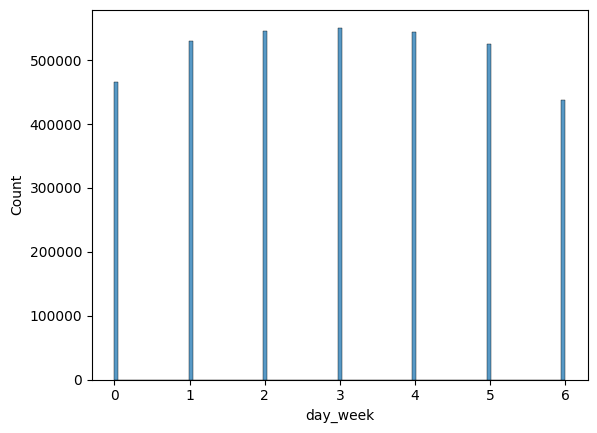

In [ ]:
sns.histplot(df["day_week"])

In [40]:
date_columns = ["duration_m","time_of_day","day_week"]

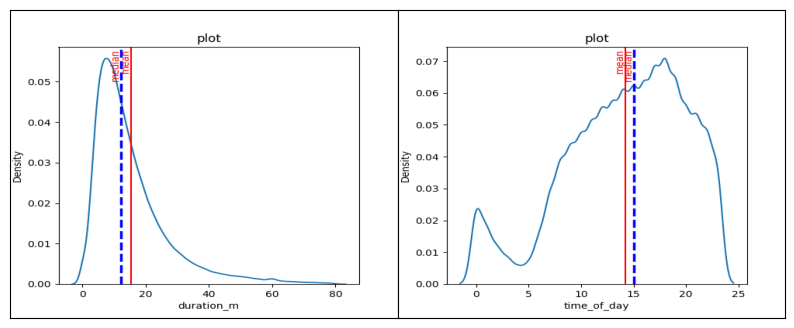

In [45]:
parallel_plot(plot_fn=plot_distribution_with_info,col_name= date_columns[:-1], grid_shape=(1, 2), figsize=(10, 4))

<Axes: xlabel='time_of_day', ylabel='Count'>

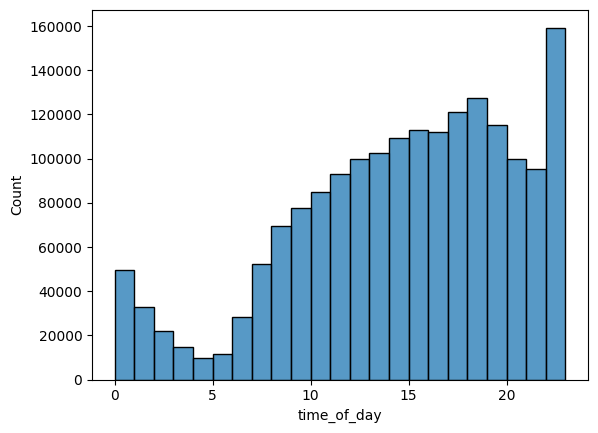

In [50]:
sns.histplot(df["time_of_day"], bins = 100,binwidth= 1, stat = 'count')

In [51]:
df['day_type'].value_counts()

workday    1281155
weekend     481424
holiday      37850
Name: day_type, dtype: int64

In [52]:
holidays = df[df['day_type']=='holiday'].reset_index(drop = True)
weekends = df[df['day_type']=='weekend'].reset_index(drop = True)
workdays =     df[df['day_type']=='workday'].reset_index(drop = True)

In [53]:
trip_filter_holiday = holidays[(holidays["trip_distance"]<=50)]["trip_distance"]
trip_filter_weekends = weekends[(weekends["trip_distance"]<=50)]["trip_distance"]
trip_filter_workday = workdays[(workdays["trip_distance"]<=50)]["trip_distance"]

In [54]:
day_type_plots = [{"holidays":holidays,"filter":trip_filter_holiday},{"weekends":weekends,"filter":trip_filter_weekends},{"workdays":workdays,"filter":trip_filter_workday}]

In [55]:
def plot_multiple_distributions(df_plots: list[dict],fig = None, figsize: tuple = (10,5), col_name: str = None, ax = None):
  cols = len(df_plots)
  fig, axes = plt.subplots(1,cols, figsize=figsize)
  axes = axes.ravel()

  for ax in range(cols):
    keys = list(df_plots[ax].keys())
    filter = None
    if col_name is None:
      filter = df_plots[ax].get(keys[1])
    plot_distribution_with_info(df_plots[ax].get(keys[0]),col_name = col_name, filter = filter,   ax = axes[ax], title = keys[0] )

  plt.show()

## Ploteando distribuciones por tipo de dia

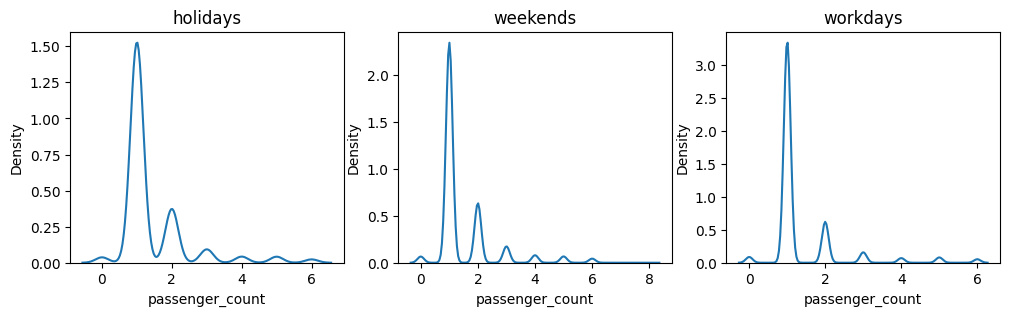

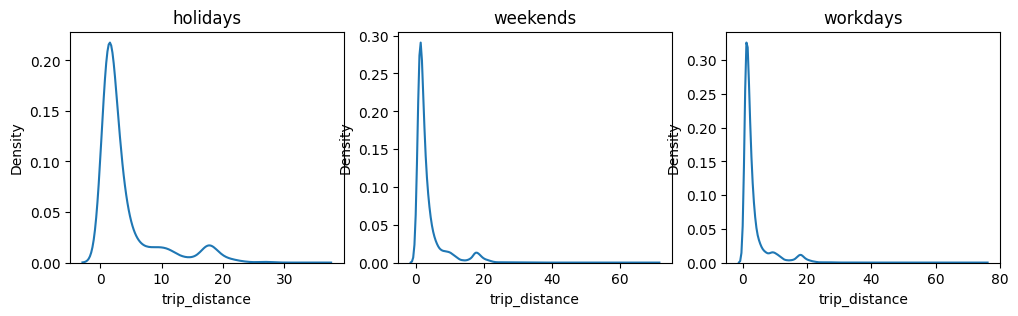

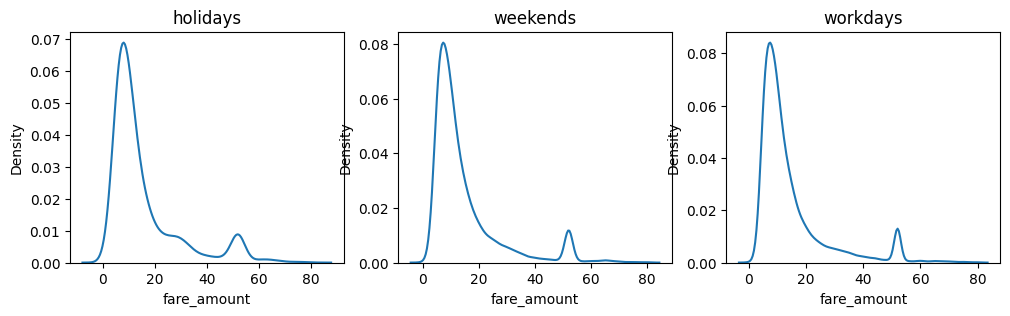

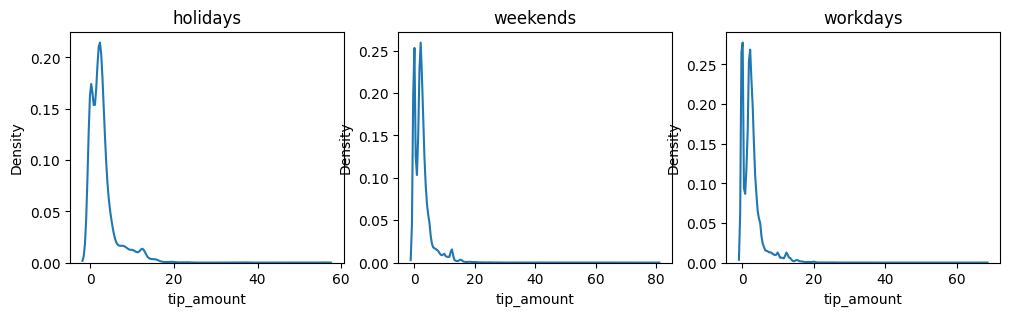

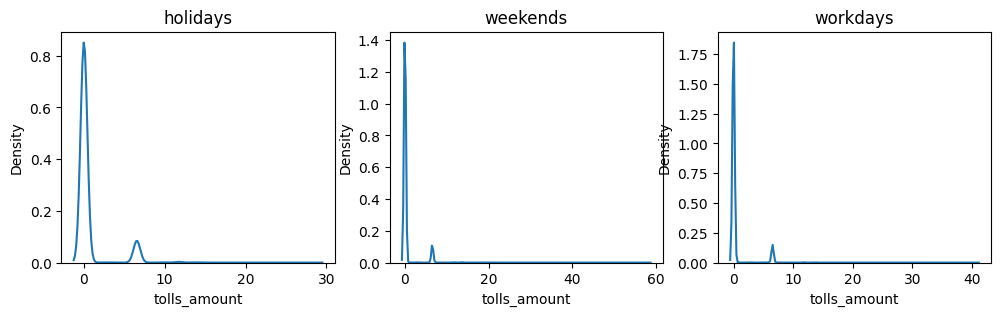

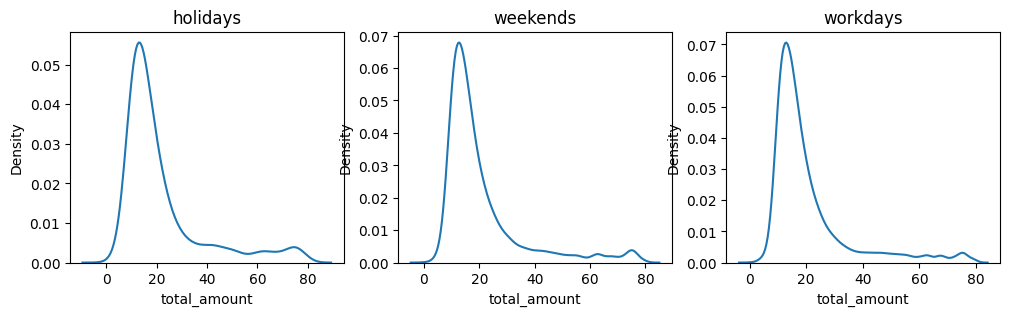

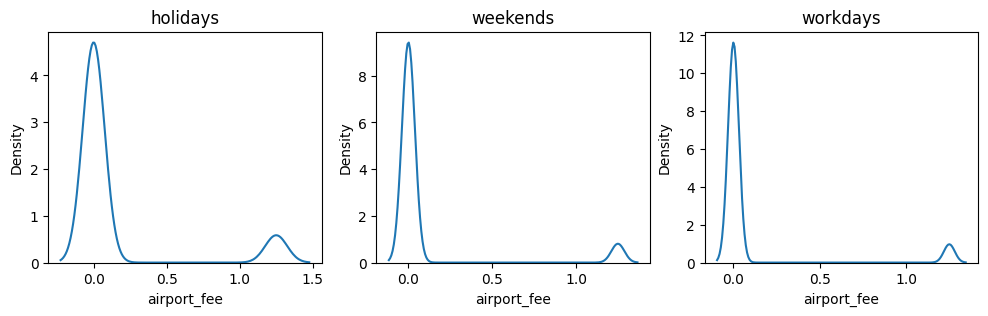

<Figure size 640x480 with 0 Axes>

In [56]:
for c in numerical_columns:
  plot_multiple_distributions(day_type_plots, figsize = (12,3), col_name = c)
plt.tight_layout()

## Utilizando data geografica

In [57]:
pu_zone = df.groupby(['PULocationID'], as_index=False).size()
do_zone = df.groupby(['DOLocationID'], as_index=False).size()
pu_zone = gpd.GeoDataFrame(pd.merge(pu_zone, geo_map, left_on='PULocationID', right_on='LocationID')).drop('LocationID', axis=1)
do_zone = gpd.GeoDataFrame(pd.merge(do_zone, geo_map, left_on='DOLocationID', right_on='LocationID')).drop('LocationID', axis=1)

In [58]:
df.groupby(['PULocationID'], as_index=False).size()

,PULocationID,size
0,1,421
1,2,3
2,3,22
3,4,2213
4,5,30
...,...,...
251,261,8941
252,262,24110
253,263,37814
254,264,21021


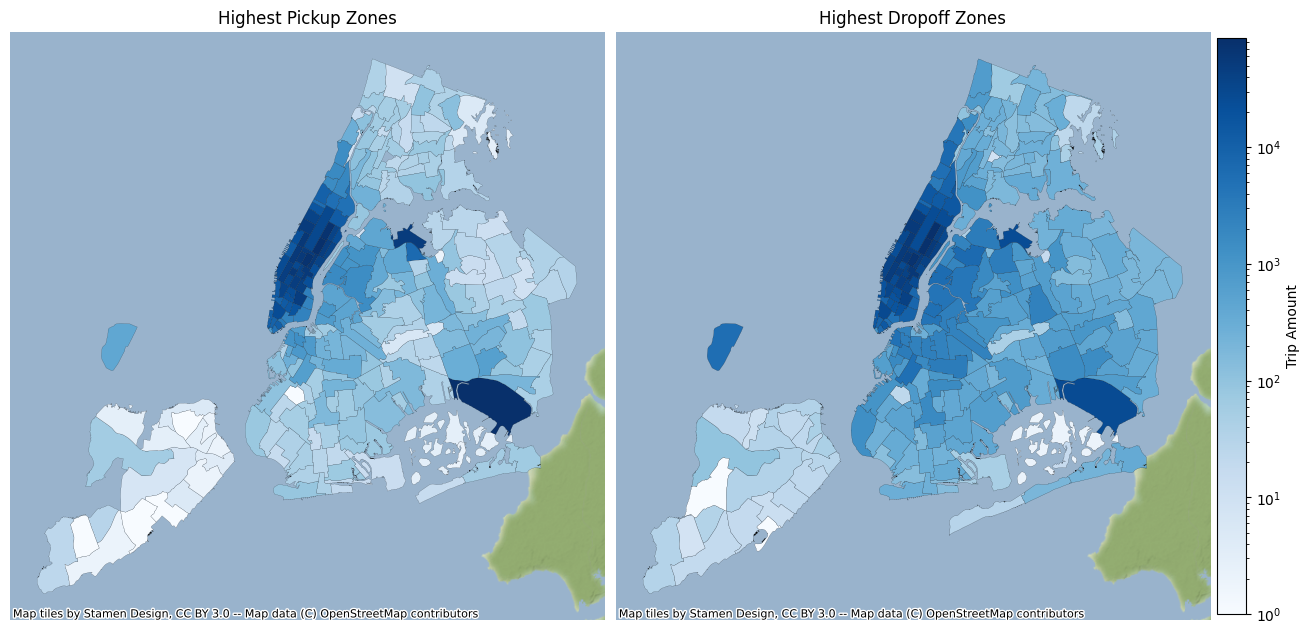

In [59]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 10))
fig.subplots_adjust(bottom=0.1, top=0.9, left=0.09, right=0.8, wspace=0.02, hspace=0.02)
# create a normalized colorbar
vmin, vmax = pu_zone['size'].min(), pu_zone['size'].max()
axs[0] = pu_zone.plot(column='size', linewidth=0.09, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[0]) 
ctx.add_basemap(axs[0])
vmin, vmax = do_zone['size'].min(), do_zone['size'].max()
axs[1] = do_zone.plot(column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10), 
    norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, ax=axs[1])
ctx.add_basemap(axs[1])
axs[0].set_title('Highest Pickup Zones')
axs[1].set_title('Highest Dropoff Zones')
axs[0].set_axis_off()
axs[1].set_axis_off()
# draw the color bar
patch_col = axs[0].collections[0]
cb = fig.colorbar(patch_col, ax=axs, shrink=0.72, orientation="vertical", pad=0.005)
cb.ax.set_ylabel('Trip Amount')
plt.show()

In [92]:
taxi_zones

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone
...,...,...,...,...
260,261,Manhattan,World Trade Center,Yellow Zone
261,262,Manhattan,Yorkville East,Yellow Zone
262,263,Manhattan,Yorkville West,Yellow Zone
263,264,Unknown,NV,NaN


In [124]:
merged_df = pd.merge(df, taxi_zones, left_on='PULocationID', right_on='LocationID')

In [125]:
merged_df = merged_df.drop(columns='LocationID')
merged_df = merged_df.rename(columns={'Borough': 'PU_borough', 'Zone': 'PU_zone', 'service_zone': 'PU_service_zone'})

In [126]:
merged_df = pd.merge(merged_df, taxi_zones, left_on='DOLocationID', right_on='LocationID')
merged_df = merged_df.drop(columns='LocationID')
merged_df = merged_df.rename(columns={'Borough': 'DO_borough', 'Zone': 'DO_zone', 'service_zone': 'DO_service_zone'})

In [127]:
merged_df

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,day_type,trips_number_by_day_type,log_duration,month,PU_borough,PU_zone,PU_service_zone,DO_borough,DO_zone,DO_service_zone
0,2022-11-20 14:50:04,2022-11-20 15:07:36,1.0,2.12,1.0,142,161,2,12.0,0.00,...,weekend,1,2.864104,November,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
1,2022-05-05 22:30:55,2022-05-05 22:43:58,1.0,1.40,1.0,142,161,1,9.5,3.30,...,workday,1,2.568788,May,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
2,2022-10-15 23:35:51,2022-10-15 23:44:19,1.0,1.20,1.0,142,161,1,7.5,2.25,...,weekend,1,2.136137,October,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
3,2022-06-22 09:05:41,2022-06-22 09:20:37,2.0,1.36,1.0,142,161,1,10.5,2.76,...,workday,1,2.703596,June,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
4,2022-01-31 23:14:25,2022-01-31 23:18:07,1.0,0.81,1.0,142,161,1,4.5,1.00,...,workday,1,1.308333,January,Manhattan,Lincoln Square East,Yellow Zone,Manhattan,Midtown Center,Yellow Zone
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1800424,2022-04-04 09:59:52,2022-04-04 10:26:35,1.0,3.50,1.0,243,59,3,18.0,0.00,...,workday,1,3.285288,April,Manhattan,Washington Heights North,Boro Zone,Bronx,Crotona Park,Boro Zone
1800425,2022-03-15 07:40:41,2022-03-15 07:58:52,1.0,1.90,1.0,169,59,2,13.0,0.00,...,workday,1,2.900505,March,Bronx,Mount Hope,Boro Zone,Bronx,Crotona Park,Boro Zone
1800426,2022-11-26 13:57:01,2022-11-26 14:19:07,2.0,6.01,1.0,170,105,1,22.0,5.06,...,weekend,1,3.095578,November,Manhattan,Murray Hill,Yellow Zone,Manhattan,Governor's Island/Ellis Island/Liberty Island,Yellow Zone
1800427,2022-09-09 13:42:11,2022-09-09 14:32:25,1.0,14.10,1.0,138,2,1,47.0,0.00,...,workday,1,3.916679,September,Queens,LaGuardia Airport,Airports,Queens,Jamaica Bay,Boro Zone


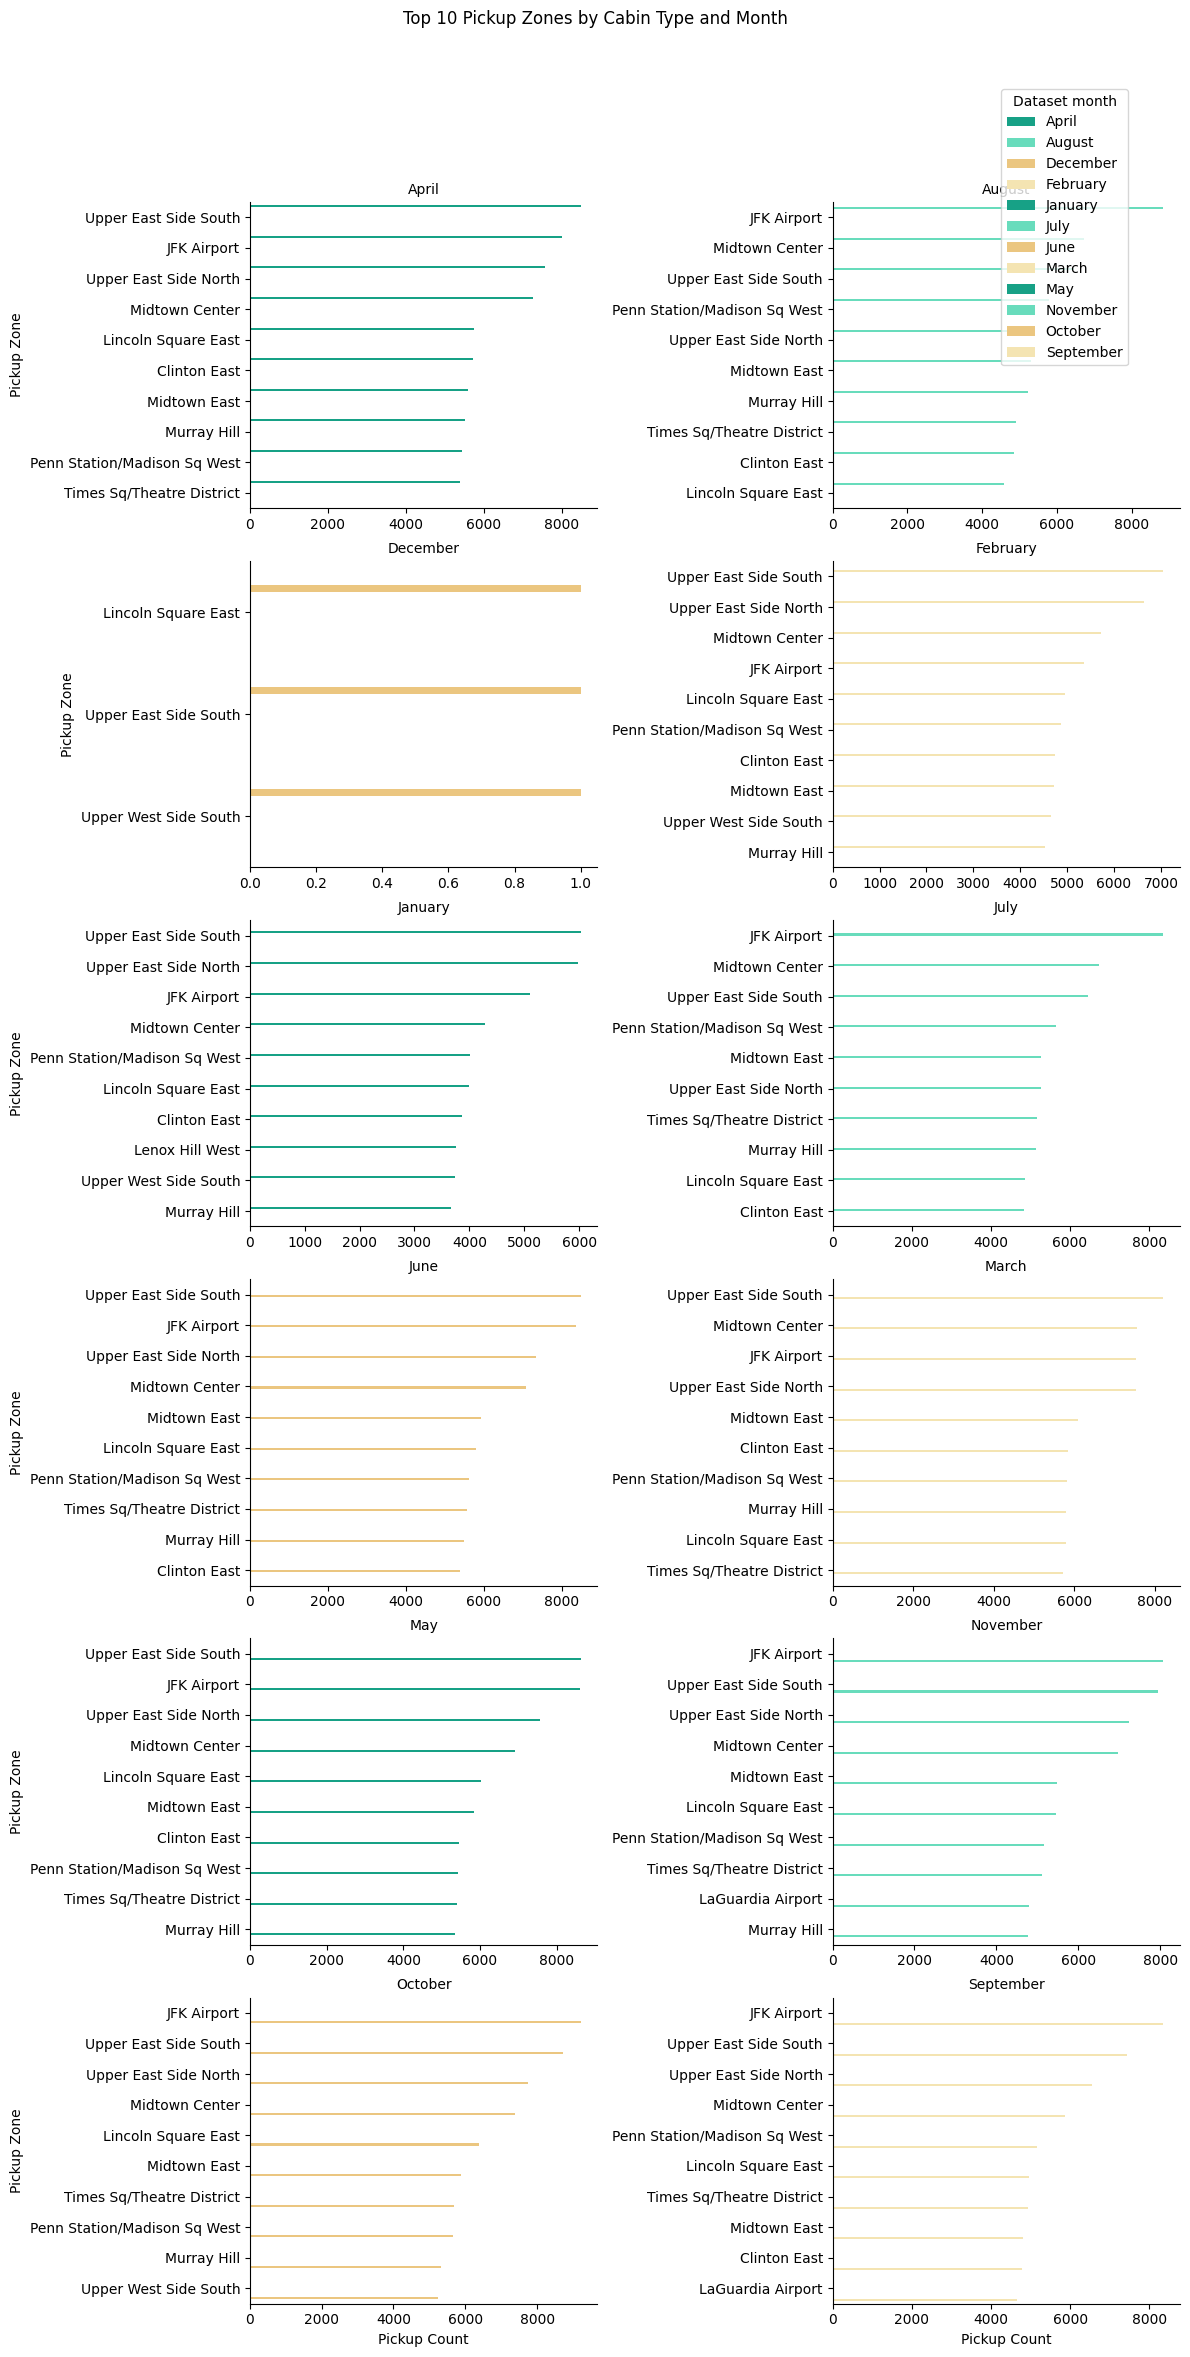

In [128]:
zones_cols = ['PU_borough', 'PU_zone', 'PU_service_zone']
pickups_by_zone = merged_df.groupby(['month', *zones_cols]).size().reset_index(name='count')

pickups_by_zone = pickups_by_zone.sort_values(['month', 'count'], ascending=[True, False]).groupby('month').head(10)

colors = sns.color_palette(['#00b894','#55efc4','#fdcb6e', '#ffeaa7'])

fig = sns.catplot(x='count', y='PU_zone', hue='month', col='month', col_wrap=2, data=pickups_by_zone, kind='bar', height=4, aspect=1.5, palette=colors, sharex=False, sharey=False)
fig.fig.subplots_adjust(top=0.9)
fig.fig.suptitle('Top 10 Pickup Zones by Cabin Type and Month')
fig.set_axis_labels('Pickup Count', 'Pickup Zone')
fig.set_titles('{col_name}')

for ax in fig.axes.flat:
    ax.legend().remove()
handles, labels = ax.get_legend_handles_labels()
fig.fig.legend(handles, labels, title='Dataset month', loc='upper right', bbox_to_anchor=(0.95, 0.95))

In [91]:
def plot_pickup_zones(df):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    ax1.scatter(df['pickup_longitude'], df['pickup_latitude'], s=0.1)
    ax1.set_title('Zonas de Recogida')
    ax1.set_xlabel('Longitud')
    ax1.set_ylabel('Latitud')
    ax2.scatter(df['dropoff_longitude'], df['dropoff_latitude'], s=0.1)
    ax2.set_title('Zonas de Llegada')
    ax2.set_xlabel('Longitud')
    ax2.set_ylabel('Latitud')

    plt.show()

In [60]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'duration_m',
       'day_of_year', 'day_week', 'day_type'],
      dtype='object')

In [ ]:
#df = df[df['date'].dt.year==2022]
#df = df[df['date'].dt.dayofyear <= 58]

In [62]:
df['date'].dt.dayofyear.min()

1

In [63]:
df['trips_number_by_day_type'] = 1
day_type_agg = df.groupby('day_type')['PULocationID'].agg('count')

In [64]:
df.columns

Index(['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count',
       'trip_distance', 'RatecodeID', 'PULocationID', 'DOLocationID',
       'payment_type', 'fare_amount', 'tip_amount', 'tolls_amount',
       'total_amount', 'airport_fee', 'date', 'time_of_day', 'duration_m',
       'day_of_year', 'day_week', 'day_type', 'trips_number_by_day_type'],
      dtype='object')

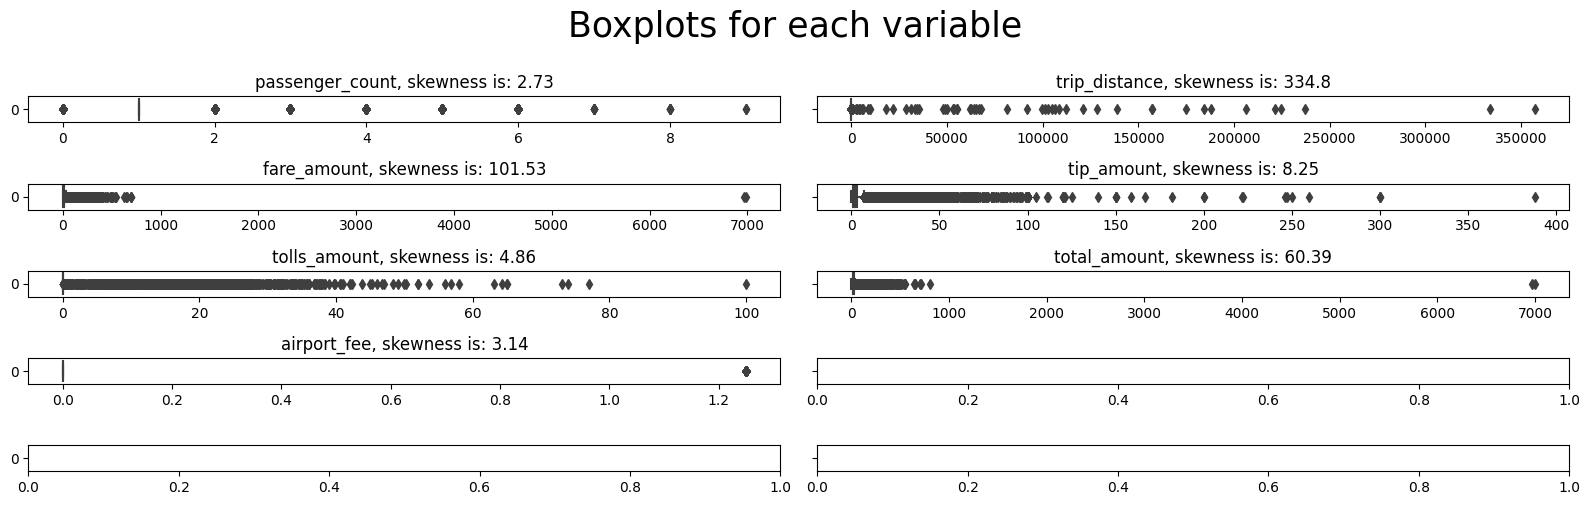

In [65]:
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numerical_columns, rows=5, cols=2, suptitle='Boxplots for each variable')
plt.tight_layout()

In [ ]:
def plot_distribution_with_info(df:pd.DataFrame = df,fig= None,col_name = None, show_info = False,ax = None, filter = None, title = 'plot'):
  """
  Makes a seaborn kdeplot from a dataFrame sample of the len(df/10), with mean and median displayed on the graph.
  """
  if (col_name is None) and (filter is None):
    return
  if col_name is not None:
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)[col_name]

  if filter is not None:
    df = filter.sample(int(np.floor(len(df)/10)),random_state = 42)
  if ax is None:
    fig, ax = plt.subplots()
  trans = ax.get_xaxis_transform()
  sns.kdeplot( df,ax= ax).set(title=title)
  if show_info:
    mean =df.mean()
    median = df.median()
    plt.axvline(x=mean,
                color='red')
    plt.text(mean, .99, 'mean', color='r', ha='right', va='top', rotation=90, transform=trans)

    plt.axvline(x=median,
                color='blue',
                ls='--', 
                lw=2.5)
    plt.text(median, .99, 'median', color='r', ha='right', va='top', rotation=90, transform=trans)

<Axes: xlabel='duration_m', ylabel='Density'>

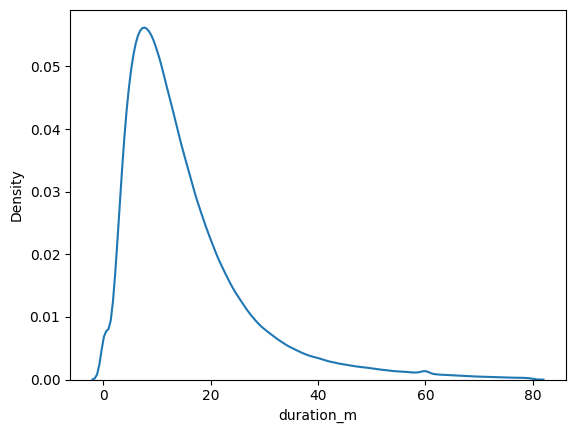

In [89]:
  sns.kdeplot(df[(df['duration_m']<=80) & (df['duration_m']>=0)]['duration_m'])

In [90]:
df_trimmed[df_trimmed['duration_m']<0]

,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,tip_amount,...,total_amount,airport_fee,date,time_of_day,duration_m,day_of_year,day_week,day_type,trips_number_by_day_type,log_duration
306,2022-04-02 18:04:58,2022-04-02 18:04:06,NaN,1.81,NaN,265,219,0,20.200001,0.0,...,21.000000,NaN,2022-04-02,18,-0.866667,04-02,5,weekend,1,NaN
2605,2022-02-03 02:02:51,2022-02-03 02:02:02,NaN,8.92,NaN,265,85,0,34.090000,0.0,...,34.889999,NaN,2022-02-03,2,-0.816667,02-03,3,workday,1,NaN
3731,2022-07-30 18:07:19,2022-07-30 18:07:15,NaN,10.27,NaN,265,95,0,41.590000,0.0,...,42.389999,NaN,2022-07-30,18,-0.066667,07-30,5,weekend,1,NaN
4400,2022-03-09 18:03:44,2022-03-09 18:03:42,NaN,4.10,NaN,265,42,0,51.200001,0.0,...,52.000000,NaN,2022-03-09,18,-0.033333,03-09,2,workday,1,NaN
5697,2022-07-20 19:07:19,2022-07-20 19:07:14,NaN,12.02,NaN,265,92,0,44.450001,0.0,...,45.250000,NaN,2022-07-20,19,-0.083333,07-20,2,workday,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1796237,2022-01-21 09:01:55,2022-01-21 09:01:37,NaN,1.33,NaN,265,42,0,15.200000,0.0,...,16.000000,NaN,2022-01-21,9,-0.300000,01-21,4,workday,1,NaN
1796760,2022-08-15 07:08:49,2022-08-15 07:08:11,NaN,10.45,NaN,265,75,0,33.250000,0.0,...,34.049999,NaN,2022-08-15,7,-0.633333,08-15,0,workday,1,NaN
1797445,2022-04-08 14:04:40,2022-04-08 14:04:09,NaN,1.48,NaN,265,95,0,64.199997,0.0,...,65.000000,NaN,2022-04-08,14,-0.516667,04-08,4,workday,1,NaN
1799089,2022-08-16 15:08:51,2022-08-16 15:08:28,NaN,4.46,NaN,265,233,0,34.200001,0.0,...,35.000000,NaN,2022-08-16,15,-0.383333,08-16,1,workday,1,NaN


<Axes: xlabel='duration_m', ylabel='Density'>

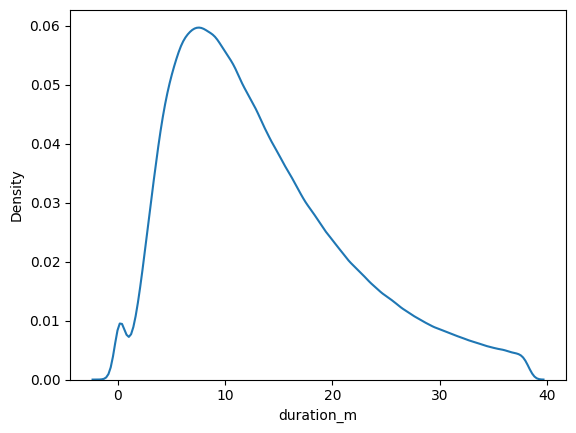

In [88]:
  sns.kdeplot(df_trimmed['duration_m'])

In [67]:
df['log_duration'] = df['duration_m'].apply(lambda x : np.log(x))

In [68]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer,MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline 

Text(0.5, 1.0, 'Modelo lineal de referencia')

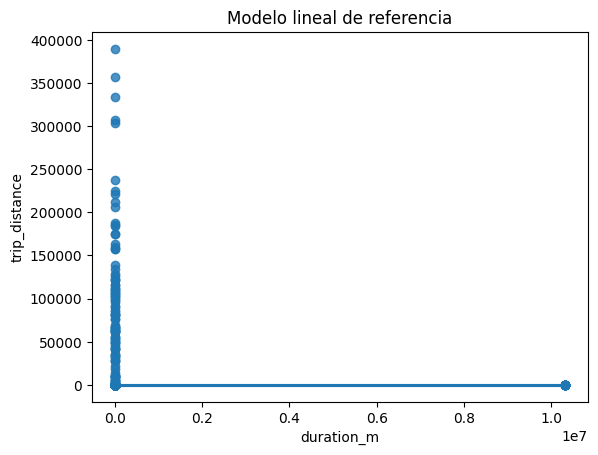

In [ ]:
#fig,axes = plt.subplots(1,1,figsize=(20,4))
#axes = axes.ravel()
sns.regplot(x="duration_m", y="trip_distance", data=df, order=1).set_title("Modelo lineal de referencia")
# sns.regplot(x="LSTAT", y="MEDV", data=df, order=1,ax=axes[1]).set_title("Aproximadamente lineal")
# sns.regplot(x="RM", y="MEDV", data=df, order=1,ax=axes[2]).set_title("Algo de linealidad")
# sns.regplot(x="CRIM", y="MEDV", data=df, order=1,ax=axes[3]).set_title("Escasa linealidad");

In [78]:
def transform_variable(df, col_name, method = "yeo-johnson"):
    power = PowerTransformer(method= method, standardize= True )
    if method == "box-cox":
      scaler = MinMaxScaler(feature_range=(1, 2))
      steps = [('s', scaler),('p', power)]
    else:
      steps = [('p', power)]
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)

    pipeline = Pipeline(
        steps=steps
    )
    X_transformed = pipeline.fit_transform(df[col_name].to_numpy().reshape(-1, 1))
    sns.histplot(X_transformed, color='r', kde=True).set_title("{} con {}($\lambda={:2f}$)".format(
                  col_name,method, pipeline.named_steps['p'].lambdas_[0]) )


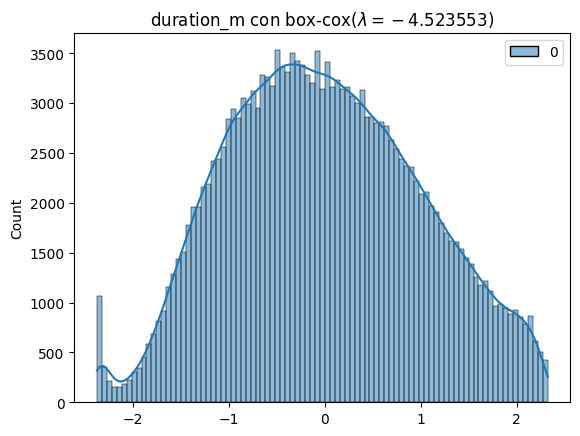

In [79]:
transform_variable(df, "duration_m", "box-cox")

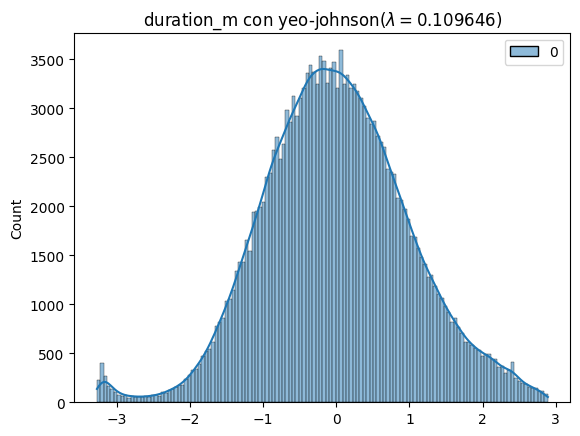

In [80]:
transform_variable(df, "duration_m")

In [81]:
def outlier_diagnostic_plots(df, col_name):
    import scipy.stats as stats
    fig, axes = plt.subplots(1,3,figsize=(20,4))
    df = df[(df[col_name]<=80) & (df[col_name]>=0)].sample(int(np.floor(len(df)/10)),random_state = 42)
    sns.histplot(df[col_name], bins=30, ax=axes[0], kde=True)
    axes[0].set_title('Histograma')
    
    stats.probplot(df[col_name], dist="norm", plot=axes[1])
    axes[1].set_title('QQ')
    
    # boxplot    
    sns.boxplot(y=df[col_name],ax=axes[2])
    axes[2].set_title('Box&Whiskers')

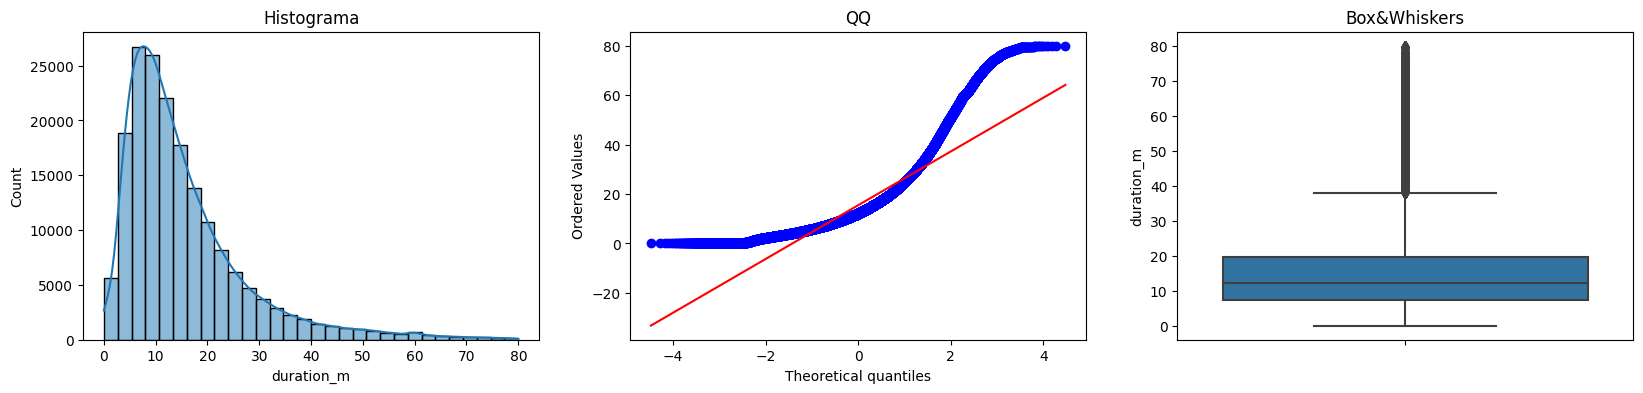

In [82]:
outlier_diagnostic_plots(df, "duration_m")

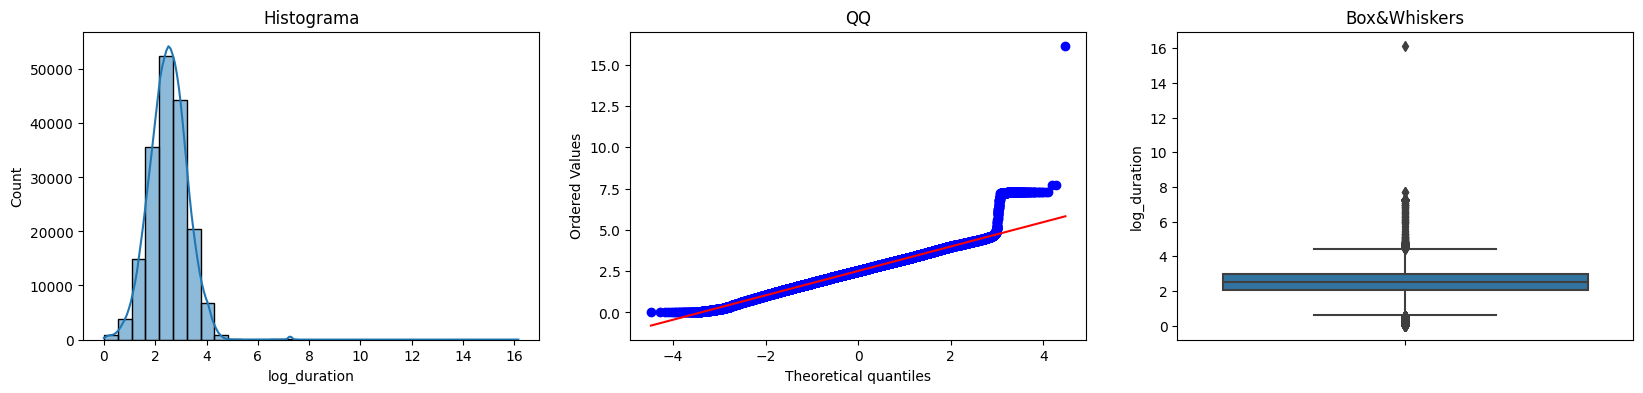

In [83]:
outlier_diagnostic_plots(df, "log_duration")

In [84]:
def find_skewed_boundaries(df, variable, distance=1.5):
    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)
    return upper_boundary, lower_boundary

In [85]:
RM_upper_limit, RM_lower_limit = find_skewed_boundaries(df, 'duration_m', 1.5)
RM_upper_limit, RM_lower_limit

(38.28333333333334, -11.050000000000004)

In [86]:
outliers_RM = np.where(df['duration_m'] > RM_upper_limit, True,
                       np.where(df['duration_m'] < RM_lower_limit, True, False))

In [87]:
df_trimmed = df.loc[~(outliers_RM), ]
df.shape, df_trimmed.shape

((1800429, 21), (1693807, 21))

In [ ]:


outliers_columns = ['duration', 'liveness', 'loudness', 'speechiness']

for col in numerical_columns:
  outlier_diagnostic_plots(df, col)

In [ ]:
tip_by_day = df.groupby(df['passenger_count'])['day_week'].mean()

In [ ]:
plt.plot(tip_by_day.index, tip_by_day.values)

# Set the title and axis labels
plt.title('Average Tip Amount by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Tip Amount')

# Display the plot
plt.show()

In [ ]:
tip_by_hour = df.groupby(df['time_of_day'])['tip_amount'].mean()

In [ ]:
plt.plot(tip_by_hour.index, tip_by_hour.values)


plt.title('Tip Amount promedio por Hora del Dia')
plt.xlabel('Hour of Day')
plt.ylabel('Tip Amount')

plt.show()

# TODO
buscar graficar la densidad de gente que toma taxis entre los dias habiles vs no habiles

In [ ]:
sns.histplot(data = df, x= 'day_type')

In [ ]:
df['trips_number'] = 1
taxi_agg = df.groupby(['day_of_year', 'PULocationID'], as_index=False).agg({'trips_number':'count'})

In [ ]:
df.groupby('day_type')['PULocationID'].agg(['count'])

In [ ]:
df['day_type'].value_counts()

In [ ]:
#df.plot.hist(column=["day_type"], by="PULocationID", figsize=(10, 8))

In [ ]:
(taxi_agg['trips_number']==0).sum()

In [ ]:
taxi_agg['PULocationID'].nunique()

In [ ]:
df['date'].dt.year.value_counts()

In [ ]:
df[df['date'].dt.dayofyear <= 59]['date'].value_counts().index.max()

In [ ]:
df_trips = pd.DataFrame(taxi_agg).set_index('day_of_year')

In [ ]:
df_types = pd.DataFrame(day_type_agg).set_index('day_type') 

In [ ]:
df_types

In [ ]:
df_trips

In [ ]:
df_types['trips_number'].plot(figsize=(18,6))

In [ ]:
df_trips

usar resample para suavizar day_of_year, verificar si la columna es type time


In [ ]:
df_trips['trips_number'].plot(figsize=(18,6))


In [ ]:
correlation_matrix = df.corr(method = 'spearman').round(2)
fig,axes = plt.subplots(1,1,figsize=(20,8))
sns.heatmap(data=correlation_matrix, annot=True,ax=axes);

In [ ]:
(trips_number_max, trips_number_min)=calculate_maxes(df,'trips_number')
(total_max, total_min)=calculate_maxes(df,'total_amount')

In [ ]:
lonmin, latmin, lonmax, latmax = geo_map.total_bounds

In [ ]:
cmap = 'jet'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax,cmap = cmap, figsize=(15,12))
#ax = geo_map[~selection].plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=total_min, vmax=total_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of payments') 

investigar modelos basados en desicion tree y regresion lineal multivariada

In [ ]:
cmap = 'jet'
fig, ax = plt.subplots(1, figsize=(15, 12))
ax = geo_map.plot(ax=ax, figsize=(15,12), cmap=cmap, scheme='quantiles')
#ax = geo_map.plot(ax=ax,color = 'gray', figsize=(15,10))
ax.axis("equal")
ax.axis([lonmin, lonmax, latmin, latmax])

for x, y, label in zip(geo_map.centroid.x, geo_map.centroid.y, geo_map.LocationID):
    ax.annotate(label, xy=(x, y), xytext=(-5, 0), textcoords="offset points", color = 'black', fontsize = 6)
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=trips_number_min, vmax=trips_number_max), cmap = cmap)
cbaxes = fig.add_axes([0.15, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cax=cbaxes)
ax.set_title('Heatmap of most recurrent zones') 

In [ ]:
df.info()

### Variables de Salida
| Nombre campo | Tipo de dato | Tipo | Significado
|-----------|-----------|-----------|-----------|
|total_amount          | float64    | Numerica| Monto total


### ¿Estan balanceadas las clases?
R/ Si

In [ ]:
df.columns

In [ ]:
s = df["trip_distance"].to_numpy().reshape(-1,1)

## 3. Limpieza y preparación de datos / ingeniería de features 

In [ ]:
# remove invalid df
# passenger == 0
df = df[(df['passenger_count'] > 0) & (df['passenger_count'] < 7)]

# trip_distance <= 0
df = df[(df['trip_distance'] > 0) & (df['trip_distance'] <= 100)]

# exclude duration longer than 180 mins
df = df[(df['duration'] > 0) & (df['duration'] <= 180)]

# payment method other than cash and credit card
df = df[(df['payment_type'] != 3) & (df['payment_type'] != 4) & (df['payment_type'] != 5) & (df['payment_type'] != 6)]

# exclude instances with fare amount less than 2.5
df = df[(df['fare_amount'] >= 2.5) & (df['fare_amount'] <= 250)]

# PU and DO location id not within NYC taxi zone
df = df[(df['PULocationID'] >= 1) & (df['PULocationID'] <= 263) & (df['DOLocationID'] >= 1) & (df['DOLocationID'] <= 263)]

### Datos faltantes. Indicar cantidad de observaciones y valores faltantes para cada variable. 

In [ ]:
df.isna().sum()

¿Qué supuestos puede realizar acerca de los datos faltantes? ¿Qué técnicas de imputación 
recomendaría? Ensayar distintas técnicas y analizar los resultados. 

### En función del estudio inicial de las variables que se hizo en la sección anterior, elegir una técnica de codificación para cada variable. Cuando lo considere apropiado, ensayar distintas técnicas y comparar los resultados, teniendo en cuenta el tipo de clasificador a utilizar. Nota: para tipos de  datos compuestos o estructurados, considerar la obtención de variables de tipo numérico/categórico.

¿Qué puede decir acerca de las relaciones entre las variables de entrada?
|

Antes de entrenar un modelo de aprendizaje automático, ¿Podría identificar las variables de 
entrada de mayor importancia? Considerar por lo menos dos técnicas para cada variable. Explique 
brevemente los métodos utilizados